# scikit-learn-random forest

Credits: Forked from [PyCon 2015 Scikit-learn Tutorial](https://github.com/jakevdp/sklearn_pycon2015) by Jake VanderPlas

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn; 
from sklearn.linear_model import LinearRegression
from scipy import stats
import pylab as pl

seaborn.set()

## Random Forest Classifier

## 随机森林分类器

Random forests are an example of an *ensemble learner* built on decision trees. For this reason we'll start by discussing decision trees themselves. 随机森林是建立在决策树基础上的*集成学习器*的一个例子。因此，我们将首先讨论决策树本身。

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification: 决策树是一种非常直观的分类或标记对象的方法：你只需提出一系列旨在集中进行分类的问题：

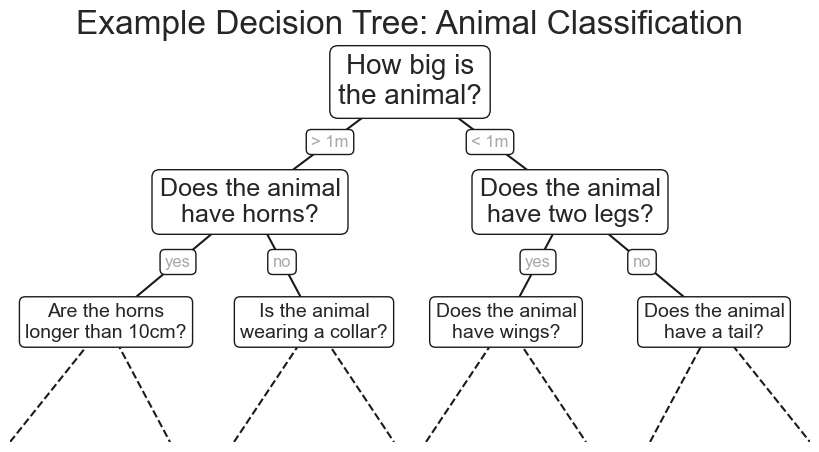

In [3]:
def plot_example_decision_tree():
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_axes([0, 0, 0.8, 1], frameon=False, xticks=[], yticks=[])
    ax.set_title('Example Decision Tree: Animal Classification', size=24)

    def text(ax, x, y, t, size=20, **kwargs):
        ax.text(x, y, t,
                ha='center', va='center', size=size,
                bbox=dict(boxstyle='round', ec='k', fc='w'), **kwargs)

    text(ax, 0.5, 0.9, "How big is\nthe animal?", 20)
    text(ax, 0.3, 0.6, "Does the animal\nhave horns?", 18)
    text(ax, 0.7, 0.6, "Does the animal\nhave two legs?", 18)
    text(ax, 0.12, 0.3, "Are the horns\nlonger than 10cm?", 14)
    text(ax, 0.38, 0.3, "Is the animal\nwearing a collar?", 14)
    text(ax, 0.62, 0.3, "Does the animal\nhave wings?", 14)
    text(ax, 0.88, 0.3, "Does the animal\nhave a tail?", 14)

    text(ax, 0.4, 0.75, "> 1m", 12, alpha=0.4)
    text(ax, 0.6, 0.75, "< 1m", 12, alpha=0.4)

    text(ax, 0.21, 0.45, "yes", 12, alpha=0.4)
    text(ax, 0.34, 0.45, "no", 12, alpha=0.4)

    text(ax, 0.66, 0.45, "yes", 12, alpha=0.4)
    text(ax, 0.79, 0.45, "no", 12, alpha=0.4)

    ax.plot([0.3, 0.5, 0.7], [0.6, 0.9, 0.6], '-k')
    ax.plot([0.12, 0.3, 0.38], [0.3, 0.6, 0.3], '-k')
    ax.plot([0.62, 0.7, 0.88], [0.3, 0.6, 0.3], '-k')
    ax.plot([0.0, 0.12, 0.20], [0.0, 0.3, 0.0], '--k')
    ax.plot([0.28, 0.38, 0.48], [0.0, 0.3, 0.0], '--k')
    ax.plot([0.52, 0.62, 0.72], [0.0, 0.3, 0.0], '--k')
    ax.plot([0.8, 0.88, 1.0], [0.0, 0.3, 0.0], '--k')
    ax.axis([0, 1, 0, 1])
    
plot_example_decision_tree()

The binary splitting makes this extremely efficient.
二进制拆分使其非常高效。
As always, though, the trick is to *ask the right questions*.
然而，像往常一样，诀窍在于 *提出正确的问题*。
This is where the algorithmic process comes in: in training a decision tree classifier, the algorithm looks at the features and decides which questions (or "splits") contain the most information.
这就是算法过程的用武之地：在训练决策树分类器时，算法会查看特征并决定哪些问题（或“拆分”）包含最多的信息。

### Creating a Decision Tree
### 创建决策树

Here's an example of a decision tree classifier in scikit-learn. We'll start by defining some two-dimensional labeled data:

以下是 scikit-learn 中决策树分类器的示例。我们将从定义一些二维标记数据开始：

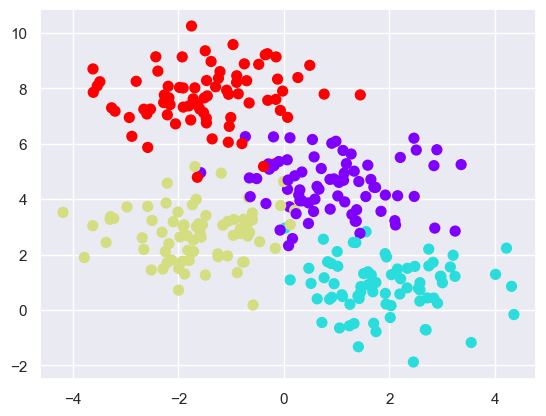

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

In [5]:
def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None):
    estimator.fit(X, y)

    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap='rainbow')
    plt.clim(y.min(), y.max())

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
    plt.axis('off')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        
    plt.clim(y.min(), y.max())
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i < 0:
            return

        tree = estimator.tree_
        
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i],
                            [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i],
                            [tree.threshold[i], xlim[1]], ylim)
        
        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim,
                            [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                            [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())

In [6]:
def plot_tree_interactive(X, y):
    from sklearn.tree import DecisionTreeClassifier

    def interactive_tree(depth=1):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    from ipywidgets import interact
    return interact(interactive_tree, depth=[1, 5])

interactive(children=(Dropdown(description='depth', options=(1, 5), value=1), Output()), _dom_classes=('widget…

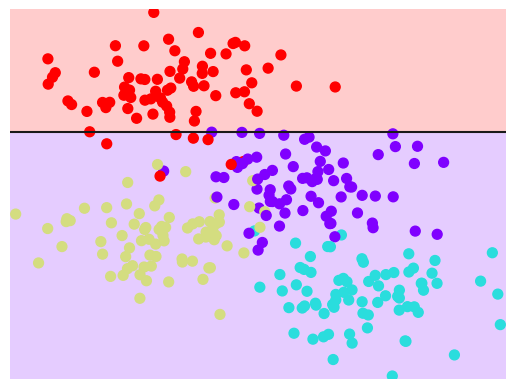

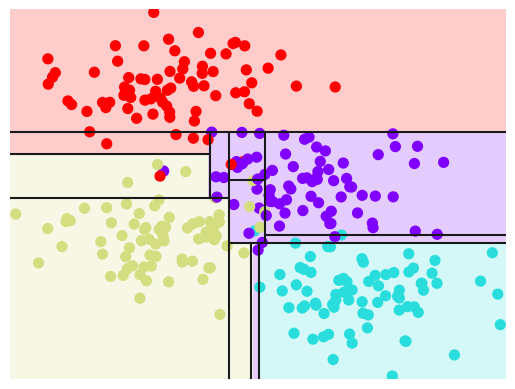

In [8]:
# Now using IPython's ``interact`` (available in IPython 2.0+, and requires a live kernel) we can view the decision tree splits:
plot_tree_interactive(X, y);

Notice that at each increase in depth, every node is split in two **except** those nodes which contain only a single class. 请注意，每次增加深度时，除了那些只包含单个类别的节点外，每个节点都会一分为二。

The result is a very fast **non-parametric** classification, and can be extremely useful in practice. 这会产生非常快速的**非参数**分类，并且在实践中非常有用。

**Question: Do you see any problems with this?**
**您觉得这有什么问题吗？**

### Decision Trees and over-fitting 决策树和过拟合

One issue with decision trees is that it is very easy to create trees which **over-fit** the data. That is, they are flexible enough that they can learn the structure of the noise in the data rather than the signal! For example, take a look at two trees built on two subsets of this dataset:
决策树的一个问题是，很容易创建过拟合数据的树。也就是说，它们足够灵活，可以学习数据中噪声的结构，而不是信号的结构！例如，看看基于此数据集的两个子集构建的两棵树：

<Figure size 640x480 with 0 Axes>

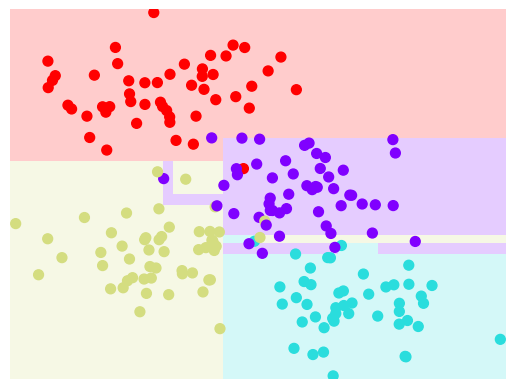

<Figure size 640x480 with 0 Axes>

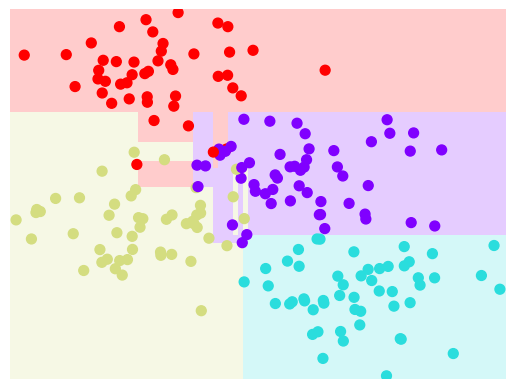

In [9]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

plt.figure()
visualize_tree(clf, X[:200], y[:200], boundaries=False)
plt.figure()
visualize_tree(clf, X[-200:], y[-200:], boundaries=False)

The details of the classifications are completely different! That is an indication of **over-fitting**: when you predict the value for a new point, the result is more reflective of the noise in the model rather than the signal.
分类的细节完全不一样！这表明**过度拟合**：当你预测一个新点的值时，结果更多地反映了模型中的噪声，而不是信号。

## Ensembles of Estimators: Random Forests
## 估计器集成：随机森林

One possible way to address over-fitting is to use an **Ensemble Method**: this is a meta-estimator which essentially averages the results of many individual estimators which over-fit the data. Somewhat surprisingly, the resulting estimates are much more robust and accurate than the individual estimates which make them up!
解决过拟合的一种可能方法是使用 **集成方法**：这是一种元估计器，它基本上对许多过拟合数据的单个估计器的结果进行平均。有点令人惊讶的是，由此产生的估计比构成它们的单个估计要稳健和准确得多！

One of the most common ensemble methods is the **Random Forest**, in which the ensemble is made up of many decision trees which are in some way perturbed.
最常见的集成方法之一是 **随机森林**，其中集成由许多以某种方式受到扰动的决策树组成。

There are volumes of theory and precedent about how to randomize these trees, but as an example, let's imagine an ensemble of estimators fit on subsets of the data. We can get an idea of what these might look like as follows:

关于如何随机化这些树，有大量的理论和先例，但举个例子，让我们想象一个在数据子集上拟合的估计器集成。我们可以通过以下方式了解它们可能是什么样子：

interactive(children=(Dropdown(description='random_state', options=(0, 100), value=0), Output()), _dom_classes…

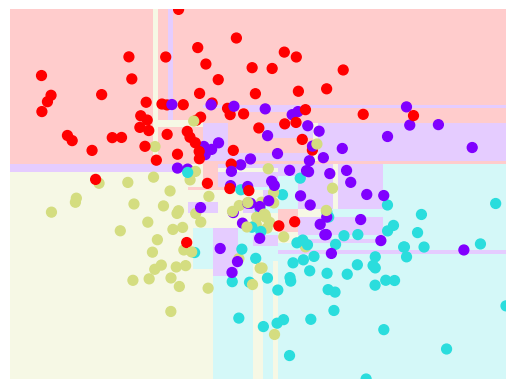

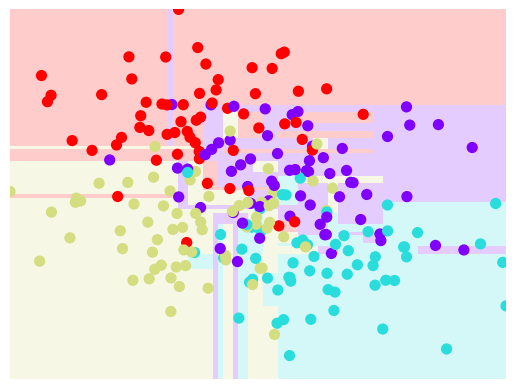

In [11]:
def fit_randomized_tree(random_state=0):
    X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=2.0)
    clf = DecisionTreeClassifier(max_depth=15)
    
    rng = np.random.RandomState(random_state)
    i = np.arange(len(y))
    rng.shuffle(i)
    visualize_tree(clf, X[i[:250]], y[i[:250]], boundaries=False,
                   xlim=(X[:, 0].min(), X[:, 0].max()),
                   ylim=(X[:, 1].min(), X[:, 1].max()))
    
from ipywidgets import interact
interact(fit_randomized_tree, random_state=[0, 100]);

See how the details of the model change as a function of the sample, while the larger characteristics remain the same!看看模型的细节是如何随着样本的变化而变化的，而整体特征却保持不变！

The random forest classifier will do something similar to this, but use a combined version of all these trees to arrive at a final answer:随机森林分类器会做类似的事情，但它会使用所有这些树的组合版本来得出最终答案：

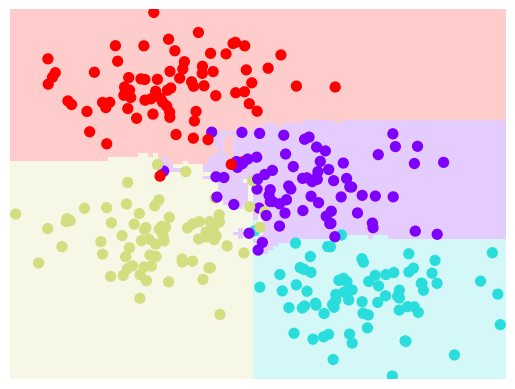

In [12]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
visualize_tree(clf, X, y, boundaries=False);

By averaging over 100 randomly perturbed models, we end up with an overall model which is a much better fit to our data!
通过对 100 个随机扰动模型进行平均，我们最终得到了一个更适合我们数据的整体模型！

*(Note: above we randomized the model through sub-sampling... Random Forests use more sophisticated means of randomization, which you can read about in, e.g. the [scikit-learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest)*)

*（注意：上面我们通过子采样对模型进行了随机化……随机森林使用更复杂的随机化方法，您可以在例如 [scikit-learn 文档](http://scikit-learn.org/stable/modules/ensemble.html#forest) 中阅读相关内容）*

## Random Forest Regressor

Above we were considering random forests within the context of classification.上文中，我们主要在分类的背景下探讨了随机森林。

Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is ``sklearn.ensemble.RandomForestRegressor``.
随机森林也可以用于回归分析（即连续变量而非分类变量）。用于此分析的估计器是“sklearn.ensemble.RandomForestRegressor”。

Let's quickly demonstrate how this can be used:让我们快速演示一下如何使用它：

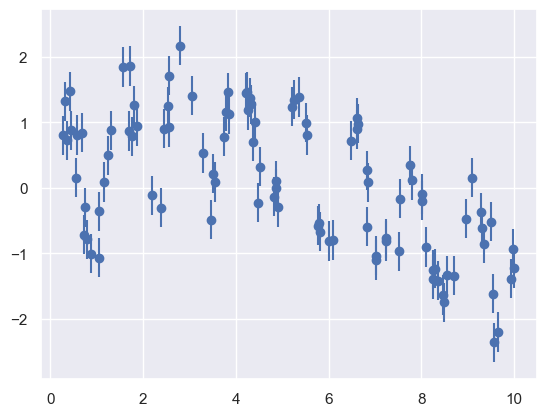

In [13]:
from sklearn.ensemble import RandomForestRegressor

x = 10 * np.random.rand(100)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * np.random.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

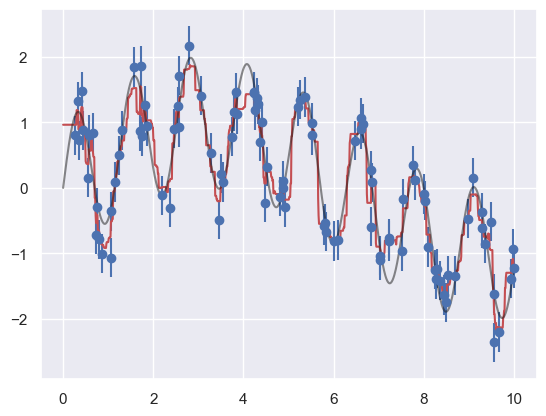

In [14]:
xfit = np.linspace(0, 10, 1000)
yfit = RandomForestRegressor(100).fit(x[:, None], y).predict(xfit[:, None])
ytrue = model(xfit, 0)

plt.errorbar(x, y, 0.3, fmt='o')
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us even specifying a multi-period model!如您所见，非参数随机森林模型足够灵活，可以拟合多周期数据，甚至无需我们指定多周期模型！

Tradeoff between simplicity and thinking about what your data is.在简洁性和思考数据本身之间进行权衡。

Feature engineering is important, need to know your domain: Fourier transform frequency distribution.
特征工程很重要，需要了解您的研究领域：傅里叶变换频率分布。

## Random Forest Limitations
## 随机森林的局限性

The following data scenarios are not well suited for random forests:
以下数据场景不适合随机森林：
* y: lots of 0, few 1    y：很多 0，很少 1
* Structured data like images where a neural network might be better  像图像这样的结构化数据，神经网络可能会更好
* Small data size which might lead to overfitting 小数据量可能会导致过拟合
* High dimensional data where a linear model might work better 高维数据，线性模型可能会更好